In [91]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [109]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gensim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.legacy import data
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
import re
import string
import unicodedata
from wordcloud import WordCloud

In [38]:
! wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-12-29 16:52:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.12.150
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.12.150|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [7]:
! pip install -q kaggle

In [8]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"likadzh","key":"ae85f84f8ad7766652f7dc3d51e2189a"}'}

In [9]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [10]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets download clmentbisaillon/fake-and-real-news-dataset -p /content/sample_data/ --unzip

 59% 24.0M/41.0M [00:00<00:00, 87.6MB/s]
100% 41.0M/41.0M [00:00<00:00, 137MB/s] 


In [32]:
df = pd.read_csv("Fake.csv")

In [33]:
df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [35]:
df.drop_duplicates(inplace = True)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23478 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23478 non-null  object
 1   text     23478 non-null  object
 2   subject  23478 non-null  object
 3   date     23478 non-null  object
dtypes: object(4)
memory usage: 917.1+ KB


In [40]:
df.subject.unique()

array(['News', 'politics', 'Government News', 'left-news', 'US_News',
       'Middle-east'], dtype=object)

In [41]:
df['code'] = df.subject.astype('category').cat.codes

In [43]:
df['text'] = df['text'] + " " + df['title']
del df['title']
del df['subject']
del df['date']

In [93]:
labels = df['code'].tolist()

In [94]:
features = []
pattern = "[^a-zA-Z]"
lemma = nltk.WordNetLemmatizer()

for txt in df.text:
    
    txt = re.sub(pattern," ",txt) # Cleaning
    txt = txt.lower() # Lowering
    txt = nltk.word_tokenize(txt) # Tokenizing
    txt = [lemma.lemmatize(word) for word in txt] # Lemmatizing
    txt = " ".join(txt)
    features.append(txt)

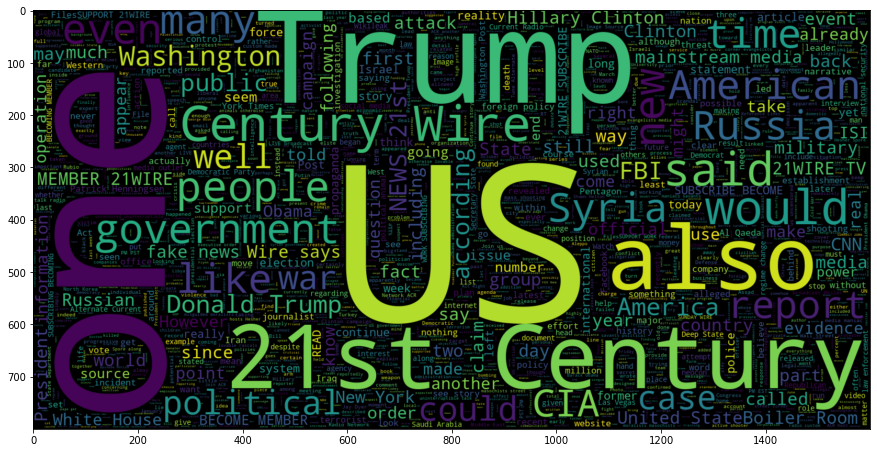

In [95]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df[df.code == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [57]:
df['code'].value_counts()

2    9050
5    6838
4    4459
0    1570
3     783
1     778
Name: code, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


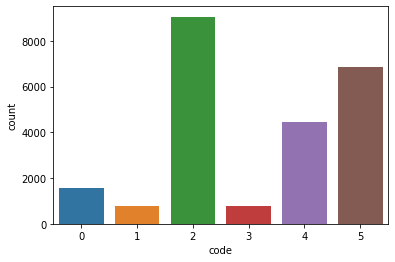

In [119]:
sns.countplot(df['code'])
plt.show()

In [71]:
#features = [word_tokenize(text) for text in features]

In [96]:
vectorizer_text = CountVectorizer(stop_words="english",max_features=4000)
text_matrix = vectorizer_text.fit_transform(features).toarray()

In [98]:
y = df.code
x = np.concatenate((np.array(df.drop("code",axis=1)),text_matrix),axis=1)

In [99]:
X_train,X_test,Y_train,Y_test = train_test_split(x,np.array(y),test_size=0.2,random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(18782, 4001)
(4696, 4001)
(18782,)
(4696,)


In [100]:
device = torch.device('cuda')

In [115]:
word2vec_txt_path = "GoogleNews-vectors-negative300.bin.gz"

In [116]:
def get_embeddings(path):
    model = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True, limit=10000)

    embeddings_index = {}
    for word, vector in zip(model.vocab, model.vectors):
        coefs = np.asarray(vector, dtype='float32')
        embeddings_index[word] = coefs

    return embeddings_index

In [81]:
embeddings_index = get_embeddings(word2vec_txt_path)

In [113]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [117]:
batch_size = 16

class CLSTM(nn.Module):
    
    def __init__(self,vocab_vectors,padding_idx,batch_size):
        super(CLSTM,self).__init__()
        print('Vocab vectors size:',vocab_vectors.shape)
        self.batch_size = batch_size
        self.hidden_dim = 128
        
        self.embedding = nn.Embedding.from_pretrained(vocab_vectors)
        self.embedding.weight.requires_grad = False
        self.embedding.padding_idx = padding_idx
        
        self.cnns =  nn.ModuleList([nn.Conv1d(in_channels=vocab_vectors.shape[1], out_channels=32, kernel_size=k) for k in [3,4,5]])
        
        self.lstm = nn.LSTM(input_size=32, 
                            hidden_size=self.hidden_dim,                             
                            bidirectional=True,
                            batch_first=True)        
        self.linear1 = nn.Linear(2*self.hidden_dim,self.hidden_dim)        
        self.linear2 = nn.Linear(self.hidden_dim,1)
        self.dropout = nn.Dropout(0.2)

    @staticmethod
    def conv_and_max_pool(x, conv):
        return F.max_pool1d(F.elu(conv(x)),1).permute(0, 2, 1)
        
    def forward(self,x):
        hidden = (torch.zeros(2, x.shape[0], self.hidden_dim).cuda(),
                torch.zeros(2, x.shape[0], self.hidden_dim).cuda())
        e = self.embedding(x)
        e = e.permute(0,2,1)
        cnn_outs = []
        for conv in self.cnns:
            f =self.conv_and_max_pool(e,conv)
            cnn_outs.append(f)
        out = torch.cat(cnn_outs, dim=1).cuda()
        _, hidden = self.lstm(out,hidden)
        out = torch.cat((hidden[0][-2,:,:], hidden[0][-1,:,:]), dim=1).cuda()
        
        return self.linear2(self.dropout(F.relu(self.linear1(out))))

In [ ]:
model = CLSTM(vectors, padding_idx=pad_token, batch_size=batch_size).cuda()

loss_function = nn.BCEWithLogitsLoss().cuda()        
optimizer = optim.Adam(model.parameters(),lr=1e-3)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
losses = []
epoch_acc=[]
lrs = []

for epoch in range(10):
    epoch_losses=[]
    preds = []
    targets = []
    acc = []
    model.train()
    for batch,train_batch in enumerate(list(iter(train_loader)),1):
        optimizer.zero_grad()
        
        y_pred = model(train_batch.text.cuda()).squeeze(1)
        y_numpy_pred =torch.sigmoid(y_pred).cpu().detach().numpy()
        preds += y_numpy_pred.tolist()
        
        y_true = train_batch.target.float().cuda()
        y_numpy_true = train_batch.target.cpu().detach().numpy()
        targets += y_numpy_true.tolist()
        loss = loss_function(y_pred,y_true)
        epoch_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        lrs.append(get_lr(optimizer))
        acc.append(accuracy_score(y_numpy_true,np.round(y_numpy_pred)))
        if batch % 100 == 0:
            print('\rtraining (batch,loss,acc) | ',batch,' ===>',loss.item(),' acc ',np.mean(acc),end='')
    
    losses.append(np.mean(epoch_losses))
    targets =  np.array(targets)
    preds = np.array(preds)
    search_result = threshold_search(targets, preds)
    train_f1 = search_result['f1']
    epoch_acc.append(np.mean(acc))
    
    print('\nEPOCH: ',epoch,'\n has acc of ',epoch_acc[-1],' ,has loss of ',losses[-1], ' ,f1 of ',train_f1)
